# 1) Loading in data and importing libraries needed later

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# logiistic regression, allows you to predict differnt classes
# patrial least sqyares regression, also used for classes sometimes
data_location = 'TCGA_GBM_LGG_Mutations_all.csv'
df = pd.read_csv(data_location)
data = df.values
#making another copy of the data to store edited values
data2 = df.values
# making another copy to store rounded ages
data_roundedages = df.values

import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score
from sklearn.metrics import RocCurveDisplay

# 2) Converting string of the age to numbers, and then sorting them into age 'bins', with 10 year intervals. Then, one-hot this to convert to binary.
From the bar graph, it is clear that there is at least some significant correlation between age and the glioma form the patient has. Because the model being used is going to take in binary variables, new 'dummy variables' should be made to store which age group a patient belongs to.

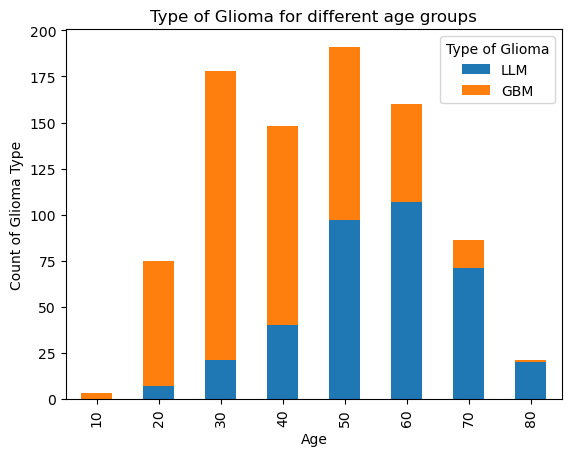

Looks like we have 35  total columns now.
['LGG' 'TCGA-LGG' 'TCGA-HW-A5KM' 'Male' 30 'Astrocytoma, NOS' 'white'
 'MUTATED' 'MUTATED' 'MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED'
 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED'
 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED'
 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 'NOT_MUTATED' 0 0 1 0 0 0 0 0]


In [2]:
for i in range(len(data[:,4])):
    trial = data[i, 4]
    trialarray = trial.split()
    #making the age from str to int (had to remove decimal because not all have it)
    #patient 42, 438, 672, 707 and 795 dont have the info, so gonna remove them
    if i != 41 and i != 437 and i != 671 and i != 706 and i != 794:
        age1 = int(trialarray[0])
        age1 = round(age1, 3)
    else:
        age1 = 50
    data2[i, 4] = age1
#print(data2[:,4])
    # editing the data array with the new ages (in integer format)
    # note to self: if this reruns, it will try to rewrite the integer, and there WILL be errors
    
###### Rounding ages to groups
for i in range(len(data2[:,4])):
    trial = data2[i, 4]
    if i != 41 and i != 437 and i != 671 and i != 706 and i != 794:
        age1 = int(trial/10)
        age1 = age1*10
    # assuming age if not given
    else:
        age1 = 50
    data2[i, 4] = age1
    
count_data = df.groupby([(data2[:, 4]), (data2[:, 0])]).size().unstack()
ax = count_data.plot(kind='bar', stacked=True)
plt.title('Type of Glioma for different age groups')
plt.xlabel('Age')
plt.ylabel('Count of Glioma Type')
legend_labels = ['LLM', 'GBM']
ax.legend(legend_labels, title='Type of Glioma')
plt.show()

# multiple options, so split the categories
ages = data2[:, 4]

# Get unique age values
unique_ages = np.unique(ages)

# Create dummy columns for each unique age
dummy_columns = [np.where(ages == age, 1, 0) for age in unique_ages]

# Add these columns to your original array
# Assuming data2 is a 2D NumPy array
data2 = np.column_stack((data2, *dummy_columns))


print("Looks like we have", data2.shape[1], " total columns now.")
print(data2[2, :])

# 3) Converting genes to mutated and not mutated in binary 0s and 1s for easier processing. Also converting gender into binary (male = 0, female = 0, and if a patient is missing gender data, deleting the row.

In [3]:
for k in range(7, 27):
    for i in range(len(data2[2:,k])+2):
        trial = data2[i, k]
        if trial == "MUTATED":
            data2[i, k] = 1
        else:
            data2[i, k] = 0
print(data2[676,0:28])


print(len(data2[2:,k])+2)
print("Looks like we have", data2.shape[1], " total columns now.")

['GBM' 'TCGA-GBM' 'TCGA-06-0166' 'Male' 50 'Glioblastoma' 'white' 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
862
Looks like we have 35  total columns now.


In [4]:
for i in reversed(range(len(data2[:, 3]))):
    trial = data2[i, 3]
    if trial == "Male":
        data2[i, 3] = 0
    if trial == "Female":
        data2[i, 3] = 1
    elif trial == "--":
        data2 = np.delete(data2, i, axis=0)
print("Looks like we have", data2.shape[0], " total rows now.")

Looks like we have 858  total rows now.


# 4) Converting race to binary variables
Observe that there is not a lot of racial diversity in the data, and in the interest of preventing overfitting, one approach is to convert to 'white' and 'nonwhite' - making this column simply binary.

In [5]:
print(len(data2[:, 0]))
print(len(data2[:, 6]))

###
# count_data = df.groupby([(data2[:, 0]), (data2[:, 6])]).size().unstack()
# ax = count_data.plot(kind='bar', stacked=True)
# plt.xlabel('Type of Glioma')
# plt.ylabel('Count')
# plt.title('Type of Glioma for different races')
# race_legend = ['Unavailable', 'American Indian/Alaska Native', 'Asian', 'Black/African American', 'Not reported', 'White']
# ax.legend(race_legend, title='Race')
# plt.show()
# ##

for i in range(len(data2[:,6])):
    trial = data2[i, 6]
    if trial == 'white':
        race = 1
    else:
        race = 0
    data2[i, 6] = race
print("Looks like we have", data2.shape[1], " total columns now.")

858
858
Looks like we have 35  total columns now.


In [6]:
print(data2[676,0:28])

['GBM' 'TCGA-GBM' 'TCGA-28-1749' 0 70 'Glioblastoma' 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


# 5) Convert the column with the 'initial diagnoses' into binary through one-hot.

print(data[:,5])
This prints us out different diagnoses of glioma, such as:
Primary_Diagnosis
Oligodendroglioma, NOS
Mixed glioma
Astrocytoma, NOS

Like for age, we'll create dummy variables, inspired by https://www.justintodata.com/logistic-regression-example-in-python/

In [7]:
# Convert LGG/GBM to 0 and 1
for i in range(len(data2[:,0])):
    trial = data2[i, 0]
    #print(trial)
    if trial == "LGG":
        data2[i,0] = 0
    else:
        data2[i,0] = 1

        
# # multiple options, so split the categories
categories_split = np.array([entry.split(',') for entry in data2[:, 5]], dtype=object)

# # make unique categories for each type
unique_categories = np.unique(categories_split)
dummy_variables = np.eye(len(unique_categories))[np.searchsorted(unique_categories, categories_split)]
data_v2 = np.concatenate((data2, dummy_variables), axis=1)
        
print(data_v2[857,:])

[1 'TCGA-GBM' 'TCGA-06-2557' 0 70 'Glioblastoma' 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0.0 0.0 1.0 0.0 0.0 0.0]


In [8]:
print("Looks like we have", data_v2.shape[1], " total columns now.")
print(data_v2[1:31, :])

Looks like we have 41  total columns now.
[[0 'TCGA-LGG' 'TCGA-QH-A6CY' ... 1.0 0.0 0.0]
 [0 'TCGA-LGG' 'TCGA-HW-A5KM' ... 0.0 0.0 0.0]
 [0 'TCGA-LGG' 'TCGA-E1-A7YE' ... 0.0 0.0 0.0]
 ...
 [0 'TCGA-LGG' 'TCGA-DU-6399' ... 0.0 1.0 0.0]
 [0 'TCGA-LGG' 'TCGA-DU-A7TA' ... 0.0 1.0 0.0]
 [0 'TCGA-LGG' 'TCGA-HT-A5RA' ... 0.0 0.0 0.0]]


# 6) Now, let's delete column 1 and 2 (redunandant information and ID taggers respectively). We have converted the initial diagnoses, and ages, to dummy variables added on to the end columns, so deleting that too. Observe that all we have now is binary variables.

In [9]:
data_v2 = np.delete(data_v2, 5, axis=1)
data_v2 = np.delete(data_v2, 4, axis=1)
data_v2 = np.delete(data_v2, 2, axis=1)
data_v2 = np.delete(data_v2, 1, axis=1)

print("Looks like we have", data_v2.shape[1], " total columns now.")
# notice that rows 2 to 22 now hold the genetic data

Looks like we have 37  total columns now.


In [10]:
print(data_v2[857, :])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0.0 0.0 1.0
 0.0 0.0 0.0]


# 7) Splitting the data into a training and testing set. The training set is 0.9 of the available data (after we've deleted the unnecessary rows, and the testing set is 0.1. 

In [11]:
kf = KFold(n_splits=10, shuffle=True)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=True)


In [12]:
#But first lets make it into a dataframe again
df = pd.DataFrame(data_v2)
random_seed = 888
df_train, df_test = train_test_split(df, test_size=0.1, random_state=random_seed, stratify=df[0])
print(df_train)
print(df_test)

    0  1  2  3  4  5  6  7  8  9   ... 27 28 29 30   31   32   33   34   35  \
383  0  0  1  1  0  0  0  0  1  0  ...  0  0  0  0  0.0  0.0  0.0  0.0  0.0   
396  0  0  1  1  0  0  0  0  1  0  ...  1  0  0  0  0.0  0.0  0.0  0.0  0.0   
299  0  1  1  1  1  1  0  0  0  0  ...  0  0  0  0  0.0  1.0  0.0  0.0  0.0   
751  1  1  1  0  1  0  1  0  0  0  ...  0  0  1  0  0.0  0.0  1.0  0.0  0.0   
668  1  0  1  0  0  0  1  0  0  0  ...  0  0  1  0  0.0  0.0  1.0  0.0  0.0   
..  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. ..  ...  ...  ...  ...  ...   
646  1  0  1  0  1  0  1  0  0  0  ...  0  0  1  0  0.0  0.0  1.0  0.0  0.0   
395  0  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  1.0  0.0  0.0  0.0  0.0   
488  0  0  1  1  1  0  0  0  0  0  ...  0  0  0  0  0.0  0.0  0.0  1.0  0.0   
650  1  0  1  0  1  0  0  0  0  1  ...  0  0  1  0  0.0  0.0  1.0  0.0  0.0   
66   0  0  1  1  0  0  0  0  1  0  ...  1  0  0  0  0.0  0.0  0.0  0.0  1.0   

      36  
383  1.0  
396  1.0  
299  0.0  
751  0.

# 8) Going from k = 1 all the way to k = 22 to capture what happens when we use all of the genes. Note that we are ALWAYS using the 'free-of-cost' variables like age, gender, etc. Note that upon closer inspection, the columns which we thought were the 'initial diagnosis' were always giving us a 100% accuracy when they were used, so they were most likely mislabeled and part of the final diagnosis.

Confusion Matrix


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


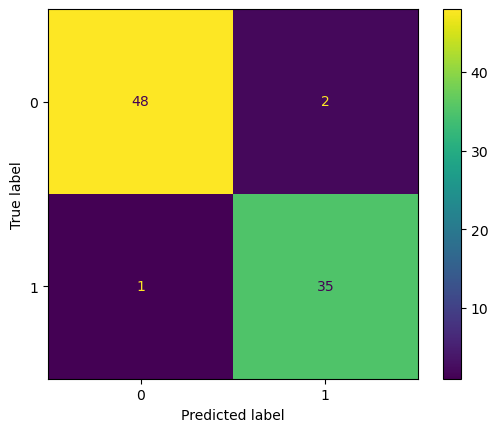

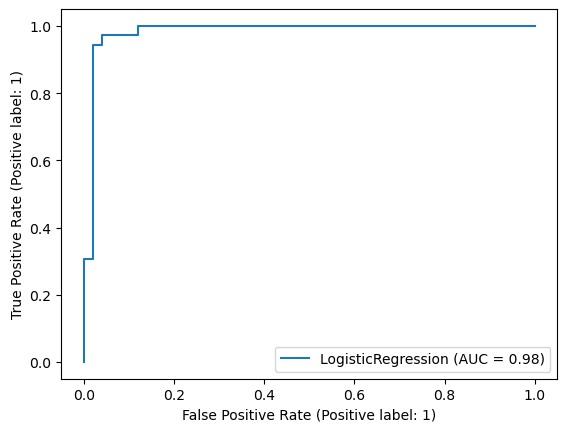

In [13]:
k = 22
# X = df_train.iloc[:, 2:k] # should be 27
X = pd.concat([df_train.iloc[:, 2:k], df_train.loc[:, 23:32], df_train.loc[:, 1]], axis=1)
y = df_train.iloc[:, 0]

X = X.astype(int)
y = y.astype(int)

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.

clf.fit(X, y)

# X_test = df_test.iloc[:, 2:k]
X_test = pd.concat([df_test.iloc[:, 2:k], df_test.loc[:, 23:32], df_test.loc[:, 1]], axis=1)
y_test = df_test.iloc[:, 0]
y_test = y_test.astype(int)
X_test = X_test.astype(int)

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

from sklearn.metrics import ConfusionMatrixDisplay
print('Confusion Matrix')
cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
#cm_display.plot()
cm_display2 = RocCurveDisplay.from_estimator(clf, X_test, y_test)

## Notice that when we use all the genes and all the information, the confusion matrix tells us we have 1 false negative and 2 false positives, so an overall (86-3)/86 = 96.5% accuracy.

# 9) Out of curiosity, what happens when we add columns of genes one at a time, in the order they were entered in the inital data table? The cell below prints out values from the confusion matrix every time a column is added. Note that although there is an upward trend in accuracy as we add more columns, not all columns help.

In [14]:
import warnings

# Suppress FutureWarning for 'penalty='none''
warnings.simplefilter(action='ignore', category=FutureWarning)

#gotta make the empty np array (for conf matrix values) first, 
# with 1 row (we'll be adding em on later) and 4 columns
accuracies = np.empty((1, 4))
accuracies = accuracies.astype(int)

for k in range(2, 22):
    # X = df_train.iloc[:, 1:k] # should be 27 (actualy 32)
    X = pd.concat([df_train.iloc[:, 2:k], df_train.loc[:, 23:32], df_train.loc[:, 1]], axis=1)
    y = df_train.iloc[:, 0]
    X = X.astype(int)
    y = y.astype(int)
    clf = LogisticRegression(penalty='none', max_iter=1000) # logistic regression with no penalty term in the cost function.
    clf.fit(X, y)
    
    X_test = pd.concat([df_test.iloc[:, 2:k], df_test.loc[:, 23:32], df_test.loc[:, 1]], axis=1)
    y_test = df_test.iloc[:, 0]
    y_test = y_test.astype(int)
    X_test = X_test.astype(int)
    
    test_prob = clf.predict_proba(X_test)[:, 1]
    test_pred = clf.predict(X_test)
    #print(test_prob, test_pred)
    
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    #cm_display.plot()
    plt.close()
    
    confusion_matrix = cm.confusion_matrix
    confusion_matrix = confusion_matrix.astype(int)
    # now, I'll extract true_pos, false_pos, false_neg, and true_neg, 
    # and store them in an array. 

    new_row = np.array([
        int(round(confusion_matrix[1, 1])),
        int(round(confusion_matrix[0, 1])),
        int(round(confusion_matrix[1, 0])),
        int(round(confusion_matrix[0, 0]))
    ])
    
    print(new_row)
    
    #accuracies.append(new_row)
    
    accuracies = np.concatenate([accuracies, [new_row]], axis=0)
    #accuracies = np.concatenate((accuracies, new_row[np.newaxis, :]), axis=0)

    #plt var 1 by var 2, coloured for accuracy to see trends

[28 11  8 39]
[28 11  8 39]
[35  4  1 46]
[35  3  1 47]
[35  3  1 47]
[35  3  1 47]
[35  3  1 47]
[35  4  1 46]
[35  4  1 46]
[35  4  1 46]
[35  4  1 46]
[35  4  1 46]
[35  4  1 46]
[35  4  1 46]
[35  3  1 47]
[35  3  1 47]
[35  3  1 47]
[35  3  1 47]
[35  3  1 47]
[35  2  1 48]


# 10) Now we know how the confusion matrix works. We want to build a model that has 85%+ accuracy but minimizes the number of genes. In the code below, we're choosing every combination of 2 genes from the 20 we have, extracting the matrix values and thus accuracy, storing them, and then printing them all at the end.

In [15]:
#print(accuracies)

In [16]:
from itertools import combinations

# remember that columns 2 to 22 now hold the genetic data, but its still 20 points to choose from
total_columns = 20
# increase this if results not good
num_columns_to_select = 2

accuracies = np.empty((0, 4))
accuracies = accuracies.astype(int)

actual_accuracy_list = np.empty((0,1))

# start at 2 because column 0 holds the results, and column 1 holds the race
column_combinations = [combo for combo in combinations(range(2, total_columns), num_columns_to_select)]
# empty list to store the order of which columns are being chosen in each iteration 
selected_columns_list = []
selected_combos_list = []

for combo in column_combinations:
    selected_columns = data[:, list(combo)]
    selected_combos_list.append(combo)
    selected_columns_list.append(selected_columns)
    
    selected_columns = pd.concat([df_train.iloc[:, list(combo)], df_train.loc[:, 23:32], df_train.loc[:, 1]], axis=1) # columns 23 ro 40 are 'free' data

    #X = df_train.iloc[:, list(combo)] # should be 27 (actualy 22)
    #X = df_train.iloc[:, list(combo)+list(range(23, 28))]
    X = df_train.iloc[:, list(combo)+list(range(1,2))+list(range(23, 32))]
    y = df_train.iloc[:, 0]
    X = X.astype(int)
    y = y.astype(int)
    clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
    clf.fit(X, y)
    
    #X_test = df_test.iloc[:, list(combo)]
    X_test = df_test.iloc[:, list(combo)+list(range(1,2))+list(range(23, 32))]
    y_test = df_test.iloc[:, 0]
    y_test = y_test.astype(int)
    X_test = X_test.astype(int)
    
    test_prob = clf.predict_proba(X_test)[:, 1]
    test_pred = clf.predict(X_test)
    #print(test_prob, test_pred)
    
    from sklearn.metrics import ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    #cm_display.plot()
    plt.close()
    confusion_matrix = cm_display.confusion_matrix
    confusion_matrix = confusion_matrix.astype(int)
    # now, I'll extract true_pos, false_pos, false_neg, and true_neg, 
    # and store them in an array. 

    new_row = np.array([
        int(round(confusion_matrix[1, 1])),
        int(round(confusion_matrix[0, 1])),
        int(round(confusion_matrix[1, 0])),
        int(round(confusion_matrix[0, 0]))
    ])
    #print(new_row)
    #accuracies.append(new_row)
    
    accuracies = np.concatenate([accuracies, [new_row]], axis=0)
    
    actual_accuracy = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
    actual_accuracy_list = np.append(actual_accuracy_list, [[actual_accuracy]], axis=0)
    print(actual_accuracy)
    # actual_accuracies = np.concatenate([actual_accuracies, actual_accuracy], axis=0)

0.8953488372093024
0.7558139534883721
0.7558139534883721
0.8023255813953488
0.7790697674418605
0.8372093023255814
0.7441860465116279
0.7558139534883721
0.7558139534883721
0.7441860465116279
0.7674418604651163
0.7674418604651163
0.7674418604651163
0.7558139534883721
0.7558139534883721
0.7558139534883721
0.7674418604651163
0.8953488372093024
0.872093023255814
0.872093023255814
0.8837209302325582
0.8837209302325582
0.8837209302325582
0.8837209302325582
0.872093023255814
0.8837209302325582
0.8837209302325582
0.8837209302325582
0.8953488372093024
0.8837209302325582
0.8837209302325582
0.8837209302325582
0.8837209302325582
0.7674418604651163
0.8023255813953488
0.7558139534883721
0.8372093023255814
0.7558139534883721
0.7674418604651163
0.7674418604651163
0.7558139534883721
0.7790697674418605
0.7790697674418605
0.7790697674418605
0.7674418604651163
0.7674418604651163
0.7674418604651163
0.7790697674418605
0.7906976744186046
0.7674418604651163
0.8372093023255814
0.7441860465116279
0.7674418604651

In [17]:
# so now I have this array of 
actual_accuracy_list.shape

(153, 1)

# 11) Now we have all the accuracy values, let's only consider the ones which are above 85% (and print the index of their genes (index as in index in our modified dataframe, where genes begin at index 2 and go to 22, too).

In [18]:
# Find indices and elements of actual_accuracy list where its above 85%
indices_above_threshold = np.where(actual_accuracy_list > 0.85)[0]
values_above_threshold = actual_accuracy_list[actual_accuracy_list > 0.85]

# Print the results
print("Indices above 0.85:", indices_above_threshold)
print("Values above 0.85:", values_above_threshold)
#observe that even though we did 20 choose 2, essentially only the earlier iterations have highest accuracy. 
# this suggests that genes in the beginning play a larger role.

for index, percent in zip(indices_above_threshold, values_above_threshold):
    print(f"Index: {index}, Percent: {percent}")
    print(f"Genes: {selected_combos_list[index]}")
    # subtracted 2 because the index will ALWAYS start at 2 because that's where our genes start in the df.


Indices above 0.85: [ 0 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 63]
Values above 0.85: [0.89534884 0.89534884 0.87209302 0.87209302 0.88372093 0.88372093
 0.88372093 0.88372093 0.87209302 0.88372093 0.88372093 0.88372093
 0.89534884 0.88372093 0.88372093 0.88372093 0.88372093 0.86046512]
Index: 0, Percent: 0.8953488372093024
Genes: (2, 3)
Index: 17, Percent: 0.8953488372093024
Genes: (3, 4)
Index: 18, Percent: 0.872093023255814
Genes: (3, 5)
Index: 19, Percent: 0.872093023255814
Genes: (3, 6)
Index: 20, Percent: 0.8837209302325582
Genes: (3, 7)
Index: 21, Percent: 0.8837209302325582
Genes: (3, 8)
Index: 22, Percent: 0.8837209302325582
Genes: (3, 9)
Index: 23, Percent: 0.8837209302325582
Genes: (3, 10)
Index: 24, Percent: 0.872093023255814
Genes: (3, 11)
Index: 25, Percent: 0.8837209302325582
Genes: (3, 12)
Index: 26, Percent: 0.8837209302325582
Genes: (3, 13)
Index: 27, Percent: 0.8837209302325582
Genes: (3, 14)
Index: 28, Percent: 0.8953488372093024
Genes: (3, 15)
Index: 29, P

# 12) Now, let's consider the ones which have a good balance between true positives and true negatives. Don't want less than 40 true negatives (or 10 false positives), and don't want less than 34 true negatives (or 2 false negatives). Let's focus on false negatives (defined as people who have the more severe GBM but the model predicts they have the less serious LGG)-prioritizing catching the more serious diagnosis. 

In [19]:
selected_indices = np.where((accuracies[:, 3] >= 40) & (accuracies[:, 0] >= 34))[0]
selected_rows = accuracies[(accuracies[:, 3] >= 40) & (accuracies[:, 0] >= 34)]

# Print the selected rows
#print(selected_rows)
for index, row in zip(selected_indices, selected_rows):
    print(f"Index: {index}, Confusion Matrix: {row}")
    print(selected_combos_list[index])

# from this, we can guess that genes in positions 3 and 5, or perhaps 4 and 5, are the most useful in making predictions. 
# note that the gene in position 2 is actually the "first" gene, because that's where the gene columns begin in our df

Index: 0, Confusion Matrix: [35  8  1 42]
(2, 3)
Index: 17, Confusion Matrix: [35  8  1 42]
(3, 4)
Index: 20, Confusion Matrix: [34  8  2 42]
(3, 7)
Index: 21, Confusion Matrix: [35  9  1 41]
(3, 8)
Index: 22, Confusion Matrix: [34  8  2 42]
(3, 9)
Index: 23, Confusion Matrix: [34  8  2 42]
(3, 10)
Index: 25, Confusion Matrix: [34  8  2 42]
(3, 12)
Index: 26, Confusion Matrix: [34  8  2 42]
(3, 13)
Index: 27, Confusion Matrix: [34  8  2 42]
(3, 14)
Index: 28, Confusion Matrix: [34  7  2 43]
(3, 15)
Index: 29, Confusion Matrix: [34  8  2 42]
(3, 16)
Index: 30, Confusion Matrix: [34  8  2 42]
(3, 17)
Index: 31, Confusion Matrix: [34  8  2 42]
(3, 18)
Index: 32, Confusion Matrix: [34  8  2 42]
(3, 19)


# 13) To visualize trends in the data that are hard to see from the raw data, making a heat map

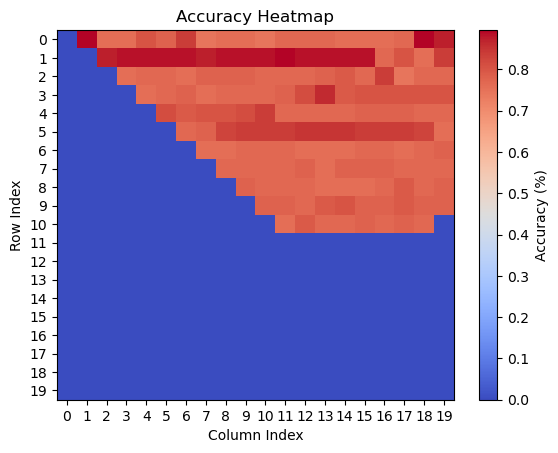

In [20]:
accuracies = np.random.rand(10, 4) * 100  
heatmap = np.zeros((20,20))

count = 0
for i in range(20):
    for j in range(i + 1, 20):
        # Check if there are still elements in actual_accuracy_list
        if count < len(actual_accuracy_list):
            # Assign the value from actual_accuracy_list to the corresponding position in heatmap
            heatmap[i, j] = actual_accuracy_list[count]
            count += 1

# # Creating a heatmap
plt.imshow(heatmap, cmap='coolwarm', aspect='auto')

# Labels, colours
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Accuracy Heatmap')
plt.colorbar(label='Accuracy (%)')
plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0, 20, 1))

plt.show()

# One interesting trend here is that genes indexed 17, 18, and 19 only really help improve prediction for the gene with index 1. There are other such trends here that are not immediately visible from the raw data, such as the gene indexed at 6 not being incredibly helpful for improving predictin besides for genes indexed 0 and 1.

# 14) Where's the Cross-Validation? Here!!! We go through the same steps (10-13) as we did above, only with some cross validation to the mix.

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

num_folds = 3 
# Array to store accuracies and conf matrix
confmatrix_cv = np.empty((0, 4))
mean_accuracy_cv = np.empty((0))

df_train = df_train.astype(int) #some of our data points are binary, but in format 0.0 / 1.0

# Define the KFold split
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for combo in combinations(range(2, total_columns), num_columns_to_select):
    selected_columns_cv = data[:, list(combo)]
    
    # Initialize lists to store results for each fold
    fold_accuracies = []
    fold_confusion_matrices = []

    for train_index, test_index in skf.split(df_train, df_train.iloc[:, 0]):  # Assuming target variable is in the first column
        X_train, X_test = df_train.iloc[train_index], df_train.iloc[test_index]
        y_train, y_test = df_train.iloc[train_index, 0], df_train.iloc[test_index, 0]  # Assuming target variable is in the first column

        # Concatenate selected columns with other relevant data
        selected_columns = pd.concat([X_train.iloc[:, list(combo)], X_train.loc[:, 23:32], X_train.loc[:, 1]], axis=1)

        # Initialize and fit the classifier
        clf = LogisticRegression(penalty='none')  # Logistic regression with no penalty term
        clf.fit(selected_columns, y_train)

        # Predict probabilities and classes for the test set
        X_test_selected = pd.concat([X_test.iloc[:, list(combo)], X_test.loc[:, 23:32], X_test.loc[:, 1]], axis=1)
        test_prob = clf.predict_proba(X_test_selected)[:, 1]
        test_pred = clf.predict(X_test_selected)

        cm_display = ConfusionMatrixDisplay.from_estimator(clf, X_test_selected, y_test)
        plt.close()
        confusion_matrix = cm_display.confusion_matrix
        confusion_matrix = confusion_matrix.astype(int)

        # Calculate actual accuracy
        actual_accuracy_cv = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
        fold_accuracies.append(actual_accuracy_cv)
        fold_confusion_matrices.append(confusion_matrix)

    # Aggregate results across folds
    mean_accuracy = np.mean(fold_accuracies, axis=0)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)

    # Extract true positive, false positive, false negative, and true negative
    new_row = np.array([
        int(round(mean_confusion_matrix[1, 1])),
        int(round(mean_confusion_matrix[0, 1])),
        int(round(mean_confusion_matrix[1, 0])),
        int(round(mean_confusion_matrix[0, 0]))
    ])

    # Append the new row to the accuracies array
    confmatrix_cv = np.concatenate([confmatrix_cv, [new_row]], axis=0)
    mean_accuracy_cv = np.concatenate([mean_accuracy_cv, [mean_accuracy]], axis=0)

    print(mean_accuracy)


0.9080626187675325
0.7901597643249981
0.7953629133612846
0.8199459073588112
0.8044168954041364
0.8380940890216069
0.7953478317698751
0.7966448486310943
0.7953478317698751
0.7953478317698751
0.8199509345559477
0.8057088850682191
0.8160699383665632
0.7940508149086559
0.7914618083833539
0.8031148513457808
0.7953428045727385
0.909354608431615
0.9106516252928344
0.9067706291034497
0.9080626187675325
0.9132506862124092
0.9080626187675325
0.9080626187675325
0.9080626187675325
0.908057591570396
0.9054786394393671
0.9080575915703958
0.9093646628258881
0.9080626187675325
0.9080626187675325
0.9080626187675325
0.9093546084316152
0.7914768899747635
0.8173518736363728
0.801822861681698
0.8380890618244704
0.7927537980474367
0.7927537980474367
0.7940508149086559
0.7927537980474367
0.8147779487024804
0.8057088850682191
0.8134759046441248
0.7914567811862175
0.7901647915221348
0.7966297670396848
0.7927487708503002
0.8212479514171669
0.8109019797102324
0.8393961330799625
0.7927739068359827
0.7940658965000

### Notice that the accuracy is actually HIGHER for most cobinations when we are doing cross validation. Perhaps because it prevented overfitting?

In [39]:
indices_above_threshold_cv = np.where(mean_accuracy_cv > 0.85)
values_above_threshold_cv = mean_accuracy_cv[mean_accuracy_cv > 0.85]

index_percent_combos_data_cv = []

for index_cv, percent_cv in zip(indices_above_threshold_cv[0], values_above_threshold_cv):
    row = {
        "Index": index_cv,
        "Percent": percent_cv,
        # "Selected Combos": selected_combos_list[index_cv]
    }
    index_percent_combos_data_cv.append(row)

index_percent_combos_df = pd.DataFrame(index_percent_combos_data_cv)
print(index_percent_combos_df)

    Index   Percent
0       0  0.908063
1      17  0.909355
2      18  0.910652
3      19  0.906771
4      20  0.908063
5      21  0.913251
6      22  0.908063
7      23  0.908063
8      24  0.908063
9      25  0.908058
10     26  0.905479
11     27  0.908058
12     28  0.909365
13     29  0.908063
14     30  0.908063
15     31  0.908063
16     32  0.909355
17     63  0.862697


In [50]:
# finding instances where false negatives is as low as possible
print(confmatrix_cv[0])
more_selected_indices_cv = np.where((confmatrix_cv[:, 3] >= 120) & (confmatrix_cv[:, 0] >= 100))[0]
more_selected_rows_cv = confmatrix_cv[(confmatrix_cv[:, 3] >= 120) & (confmatrix_cv[:, 0] >= 100)]

min_f_negatives = []

for index_cv, row_cv in zip(more_selected_indices_cv, more_selected_rows_cv):
    row = {
        "Index": index_cv,
        "Row": row_cv,
        "Percent": percent_cv,
        "Selected Combos": selected_combos_list[index_cv]
    }
    min_f_negatives.append(row)
    if index_cv == 152:
        break

min_f_negatives_df = pd.DataFrame(min_f_negatives)
print(min_f_negatives_df)

[100.  16.   8. 133.]
    Index                        Row   Percent Selected Combos
0       0  [100.0, 16.0, 8.0, 133.0]  0.862697          (2, 3)
1      17  [101.0, 16.0, 7.0, 133.0]  0.862697          (3, 4)
2      18  [101.0, 16.0, 7.0, 134.0]  0.862697          (3, 5)
3      19  [100.0, 16.0, 8.0, 133.0]  0.862697          (3, 6)
4      20  [100.0, 16.0, 8.0, 133.0]  0.862697          (3, 7)
5      21  [100.0, 14.0, 8.0, 135.0]  0.862697          (3, 8)
6      22  [100.0, 16.0, 8.0, 133.0]  0.862697          (3, 9)
7      23  [100.0, 16.0, 8.0, 133.0]  0.862697         (3, 10)
8      24  [100.0, 16.0, 8.0, 133.0]  0.862697         (3, 11)
9      25  [101.0, 16.0, 7.0, 133.0]  0.862697         (3, 12)
10     26  [100.0, 16.0, 8.0, 133.0]  0.862697         (3, 13)
11     27  [101.0, 16.0, 7.0, 133.0]  0.862697         (3, 14)
12     28  [100.0, 15.0, 8.0, 134.0]  0.862697         (3, 15)
13     29  [100.0, 16.0, 8.0, 133.0]  0.862697         (3, 16)
14     30  [100.0, 16.0, 8.0, 133

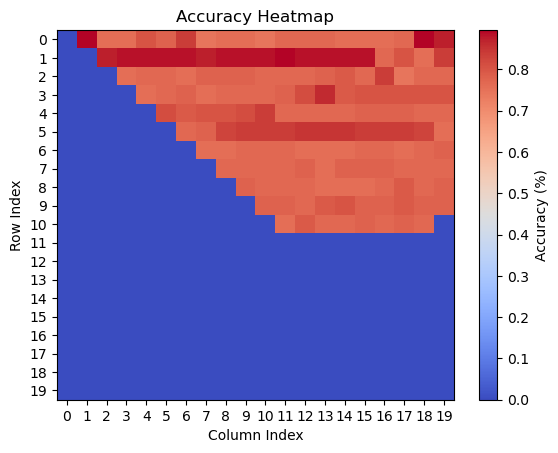

In [51]:
accuracies_cv_heatmap = np.random.rand(10, 4) * 100  
heatmap_cv = np.zeros((20,20))

count = 0
for i in range(20):
    for j in range(i + 1, 20):
        # Check if there are still elements in actual_accuracy_list
        if count < len(mean_accuracy_cv):
            # Assign the value from actual_accuracy_list to the corresponding position in heatmap
            heatmap_cv[i, j] = mean_accuracy_cv[count]
            count += 1

# # Creating a heatmap
plt.imshow(heatmap, cmap='coolwarm', aspect='auto')

# Labels, colours
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Accuracy Heatmap')
plt.colorbar(label='Accuracy (%)')
plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0, 20, 1))

plt.show()

In [52]:
## Our cross validated results agree a lot with our results